Import some essential libraries

In [2]:
import pickle
# Essential for data manipulation
import numpy as np

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

In [3]:
tf.__version__

'2.4.1'

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# 1. Import data, split to train, validation, test set:

In [5]:
# Data directory
train_dir = '/storage/intern/train'
val_dir = "/storage/intern/val"

In [6]:
batch_size = 32
img_size = (224, 224)
fold_chosen = 2

In [7]:
train_ds = image_dataset_from_directory(train_dir,
                                        seed=42,
                                        image_size=img_size,
                                        batch_size=batch_size)

Found 49828 files belonging to 41 classes.


In [8]:
val_ds = image_dataset_from_directory(val_dir,
                                      seed=42,
                                      image_size=img_size,
                                      batch_size=batch_size)

Found 12667 files belonging to 41 classes.


In [9]:
# Create test set
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

Class name

In [10]:
# Class specification
class_names = train_ds.class_names
print(len(class_names))
print(class_names)

41
['GGｻｲｹﾃﾞﾘｯｸｽﾌﾟﾘｰﾑｷｬﾝﾊﾞｽ', 'GGｼﾞｬｶｰﾄﾞﾃﾞﾆﾑ', 'GGﾅｲﾛﾝ(ECONYL)', 'calf', 'canvas', 'coatedcanvas', 'crocodile', 'denim', 'enamel', 'flora canvas', 'fur', 'gg crystal', 'gg embossed leather', 'gg imprime ', 'gg nylon', 'gg plus', 'gg supreme canvas', 'ggcanvas', 'guccissima', 'guccissima nylon', 'leather', 'linen', 'lizard', 'microguccissima', 'nylon', 'ostrich', 'python', 'quilted leather', 'suede', 'velvet', 'wool', 'ｳﾞｨﾝﾃｰｼﾞｷｬﾝﾊﾞｽ', 'ｷｬﾝﾊﾟｽ+ﾚｻﾞｰ', 'ｽﾀｰﾌﾟﾘﾝﾄGGｽﾌﾟﾘｰﾑｷｬﾝﾊﾞｽ', 'ｽﾈｰｸ', 'ｽﾈｰｸﾌﾟﾘﾝﾄGGｽﾌﾟﾘｰﾑｷｬﾝﾊﾞｽ', 'ﾊｰﾄﾌﾟﾘﾝﾄGGｽﾌﾟﾘｰﾑｷｬﾝﾊﾞｽ', 'ﾏｲｸﾛGGﾌﾟﾗｽ', 'ﾏｲｸﾛｸﾞｯﾁｯｼﾏｸﾞﾛｯｼｰﾊﾟﾃﾝﾄﾚｻﾞｰ', 'ﾐﾆGGｽﾌﾟﾘｰﾑｷｬﾝﾊﾞｽ', 'ﾚｻﾞｰ+ｷｬﾝﾊﾞｽ']


In [11]:
# Pickle class_name
label_path = f"./mat/MatLB{fold_chosen}"
f = open(label_path, "wb")
f.write(pickle.dumps(class_names))
f.close()

## Visualize the data

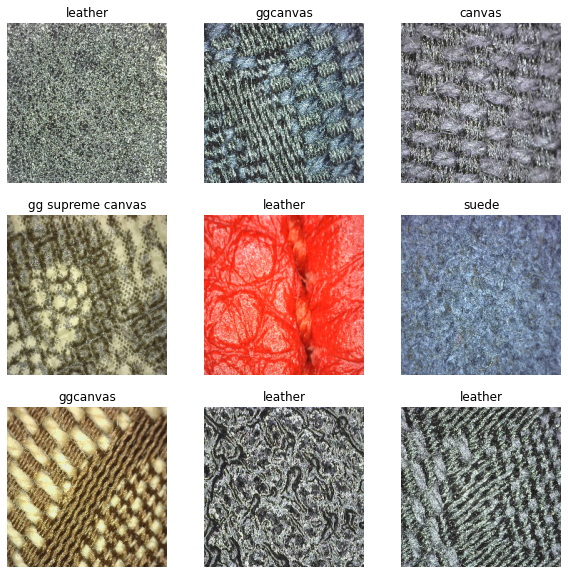

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


## Config dataset for better performance

In [14]:
# Preprocess
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = tf.keras.applications.efficientnet.preprocess_input(resized_image)
    return final_image, label

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(preprocess).cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.map(preprocess).cache().prefetch(AUTOTUNE)
test_ds = test_ds.map(preprocess).cache().prefetch(AUTOTUNE)

# 2. Compose the model

Create the base model from the pre-trained EfficientNetB3

In [16]:
img_shape = img_size + (3,)

In [17]:
# Create the base model from the pre-trained model EfficientNetB3
base_model = EfficientNetB3(input_shape=img_shape,
                            include_top=False, 
                            weights='imagenet')

In [18]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

### Build model

In [20]:
# Build model
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)
output = Dense(len(class_names), activation='softmax')(x)
model = keras.Model(inputs=base_model.input, outputs=output)

In [21]:
# Freeze for pre-trained learning
for layer in base_model.layers:
    layer.trainable = False
# Compile
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer,
              metrics=["accuracy"])

In [22]:
# Feature extraction
initial_epochs = 5
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=initial_epochs)

Epoch 1/5
1558/1558 [==============================] - 2774s 895ms/step - loss: 1.5594 - accuracy: 0.6838 - val_loss: 1.0618 - val_accuracy: 0.7333
Epoch 2/5
1558/1558 [==============================] - 213s 137ms/step - loss: 0.6406 - accuracy: 0.7878 - val_loss: 0.9836 - val_accuracy: 0.7468
Epoch 3/5
1558/1558 [==============================] - 213s 137ms/step - loss: 0.5796 - accuracy: 0.7977 - val_loss: 0.9620 - val_accuracy: 0.7528
Epoch 4/5
1558/1558 [==============================] - 213s 137ms/step - loss: 0.5453 - accuracy: 0.8123 - val_loss: 0.9605 - val_accuracy: 0.7480
Epoch 5/5
1558/1558 [==============================] - 213s 137ms/step - loss: 0.5181 - accuracy: 0.8165 - val_loss: 0.9435 - val_accuracy: 0.7514


In [23]:
# Save feature extraction model
fe_model_path = f"./mat/model/MatFEModel_K{fold_chosen}.h5"
model.save(fe_model_path)

## Learning curves

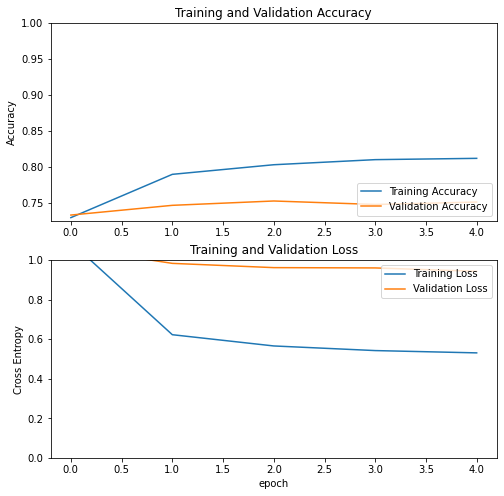

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# 3. Fine-tunning the model

In [ ]:
# Reload the FE model
# model = keras.models.load_model(fe_model_path)

Recompile

In [25]:
# Unfreeze all layer
for layer in base_model.layers:
    layer.trainable = True
# Recompile
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer,
              metrics=["accuracy"])

In [26]:
# Fine-tunning
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=fine_tune_epochs)

Epoch 1/5
1558/1558 [==============================] - 942s 597ms/step - loss: 0.8658 - accuracy: 0.7496 - val_loss: 0.9954 - val_accuracy: 0.7714
Epoch 2/5
1558/1558 [==============================] - 929s 597ms/step - loss: 0.2104 - accuracy: 0.9218 - val_loss: 1.1989 - val_accuracy: 0.7652
Epoch 3/5
1558/1558 [==============================] - 929s 596ms/step - loss: 0.1052 - accuracy: 0.9613 - val_loss: 1.3448 - val_accuracy: 0.7671
Epoch 4/5
1558/1558 [==============================] - 929s 597ms/step - loss: 0.0653 - accuracy: 0.9776 - val_loss: 1.4518 - val_accuracy: 0.7581
Epoch 5/5
1558/1558 [==============================] - 929s 596ms/step - loss: 0.0457 - accuracy: 0.9854 - val_loss: 1.5289 - val_accuracy: 0.7607


In [27]:
# Save fine-tuned model
final_model = f"./mat/model/MatK{fold_chosen}_1.0.h5"
model.save(final_model)

Learning curves

In [28]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

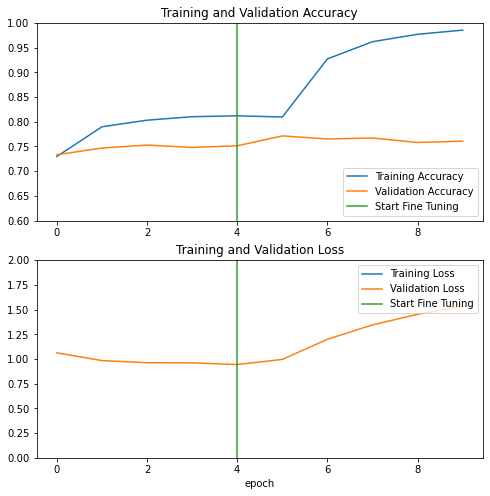

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# 4. Evaluation and prediction

Evaluate on test set

In [30]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

79/79 [==============================] - 117s 1s/step - loss: 1.4335 - accuracy: 0.7820
Test accuracy : 0.7820411324501038


Predict on test set

Predictions:
 [20 12 20  7  4 20 18 16 16 16 20  4  4 17 17 17 17  4 17  4 20 20 17 16
 20  4 17 16 16 16  4  4]
Labels:
 [20 12 20  7 17 20 18 28 16 16 20 17  4  4 17 17 17  4 17 17 20 20 17 16
 20  4  4 16 15 16 17  4]


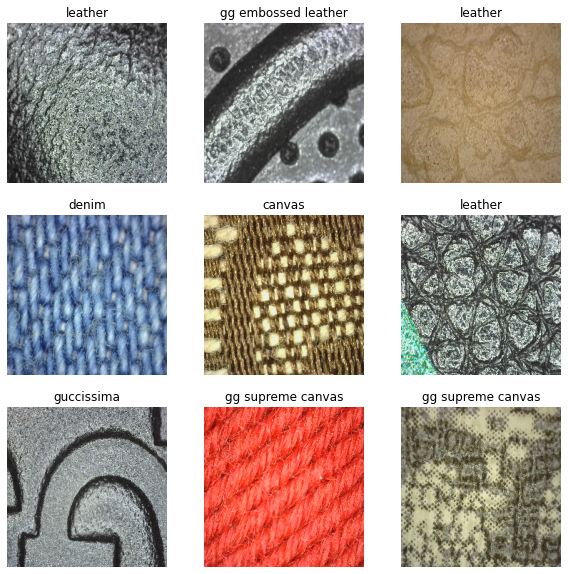

In [31]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = np.argmax(predictions, axis = 1)
 
print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")